In [8]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
#from model_training_process import *
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
print(f"tf.config.list_physical_devices('GPU'): {tf.config.list_physical_devices('GPU')}")

tf.config.list_physical_devices('GPU'): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
import numpy as np
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def get_cnn_model(input_shape, num_classes, learning_rate=0.001, num_filters=32, dense_units=256):
    cnn_model = Sequential()

    # 第一層捲積層
    cnn_model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    # 第二層捲積層
    cnn_model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    # 第三層捲積層
    cnn_model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    # 展平
    cnn_model.add(Flatten())

    # 第一層全連接層
    cnn_model.add(Dense(dense_units))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))

    # 第二層全連接層
    cnn_model.add(Dense(dense_units * 2))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))

    # 第三層全連接層(長度同為1467個label)
    cnn_model.add(Dense(num_classes))

    # 表示為機率
    cnn_model.add(Activation('softmax'))

    cnn_model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return cnn_model

def get_processed_data(X, y, num_classes, mfcc_dim_1, mfcc_dim_2, channel, test_size):
    scaler = StandardScaler()

    # 因為標準器只能fit 2維的資料所以要將3維的mfcc資料集reshape成2維
    # mfcc_data_nums: k
    # mfcc_row: n
    # mfcc_column: m
    # (k, n, m) => (k * n, m)
    scaler.fit(
        X.reshape(
            (X.shape[0] * X.shape[1], X.shape[2])
        )
    )

    X_scaled = np.array([scaler.transform(data) for data in X])

    # 將int label轉換成二進制one hot標籤
    y_one_hot = to_categorical(y, num_classes=num_classes)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=test_size, random_state=42)

    X_train = X_train.reshape(X_train.shape[0], mfcc_dim_1, mfcc_dim_2, channel)
    X_test = X_test.reshape(X_test.shape[0], mfcc_dim_1, mfcc_dim_2, channel)

    return X_train, X_test, y_train, y_test


In [4]:
class_df = pd.read_csv(filepath_or_buffer="..\\..\\cnn_method2\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df

,bopomofo,pinyin,hu_yin,she2_yin,hu_yin_label,she2_yin_label,class_label
0,ㄓ,zhi,純聲符,翹舌音,0,5,0
1,ㄔ,chi,純聲符,翹舌音,0,5,0
2,ㄕ,shi,純聲符,翹舌音,0,5,0
3,ㄖ,ri,純聲符,翹舌音,0,5,0
4,ㄗ,zi,純聲符,平舌音,0,6,1
...,...,...,...,...,...,...,...
402,ㄒㄩㄣ,xun,撮口呼,舌面音,4,4,20
403,ㄩㄥ,yong,撮口呼,純韻符,4,0,18
404,ㄐㄩㄥ,jiong,撮口呼,舌面音,4,4,20
405,ㄑㄩㄥ,qiong,撮口呼,舌面音,4,4,20


In [5]:
npy_file_path = glob("..\\..\\data\\*EduVer\\*.npy", recursive=True)
print(f"len(npy_file_path) = {len(npy_file_path)}")

len(npy_file_path) = 67173


In [6]:
npy_file_path_selected = list()
for npy_file in npy_file_path:
    pinyin = npy_file.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        npy_file_path_selected.append(npy_file)
print(f"len(npy_file_path_selected) = {len(npy_file_path_selected)}")

len(npy_file_path_selected) = 66852


In [9]:
data_class_label = list()
for npy_file in tqdm(npy_file_path_selected):
    pinyin = npy_file.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "hu_yin_label"].iloc[0]
    data_class_label.append(class_label)
data_class_label = np.array(data_class_label)
print(f"len(data_class_label) = {len(data_class_label)}")

100%|██████████| 66852/66852 [00:11<00:00, 5853.56it/s]

len(data_class_label) = 66852


In [10]:
mfcc_matrix_list = list()
for npy_file in tqdm(npy_file_path_selected):
    mfcc_matrix = np.load(npy_file)
    mfcc_matrix_list.append(mfcc_matrix)
mfcc_matrix_list = np.array(mfcc_matrix_list)
print(f"len(mfcc_matrix_list) = {len(mfcc_matrix_list)}")

100%|██████████| 66852/66852 [02:45<00:00, 405.12it/s] 


len(mfcc_matrix_list) = 66852


In [11]:
best_params = json.load(open(f"..\\..\\grid_search\\method2_with_fake_data\\layer1\\best_params.json", "r"))

learning_rate = best_params["learning_rate"]
num_filters = best_params["num_filters"]
dense_units = best_params["dense_unit"]
batch_size = best_params["batch_size"]
epochs = best_params["epochs"]

channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2
mfcc_dim_1 = mfcc_matrix_list.shape[1]
mfcc_dim_2 = mfcc_matrix_list.shape[2]
print(f"mfcc_dim_1: {mfcc_dim_1}")
print(f"mfcc_dim_2: {mfcc_dim_2}")

mfcc_dim_1: 13
mfcc_dim_2: 44


In [13]:
X_train, X_test, y_train, y_test = get_processed_data(
    X=mfcc_matrix_list,
    y=data_class_label,
    num_classes=num_classes,
    mfcc_dim_1=mfcc_dim_1,
    mfcc_dim_2=mfcc_dim_2,
    channel=channel,
    test_size=test_size,
)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (53481, 13, 44, 1)
y_train.shape: (53481, 407)
X_test.shape: (13371, 13, 44, 1)
y_test.shape: (13371, 407)


In [14]:
model = get_cnn_model(input_shape=(mfcc_dim_1, mfcc_dim_2, channel), num_classes=num_classes, learning_rate=learning_rate, num_filters=num_filters, dense_units=dense_units)
model_train_info = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test))

Epoch 1/500
1672/1672 - 81s - loss: 1.0968 - accuracy: 0.6342 - val_loss: 0.8896 - val_accuracy: 0.6493 - 81s/epoch - 49ms/step
Epoch 2/500
1672/1672 - 62s - loss: 0.7352 - accuracy: 0.7022 - val_loss: 0.7072 - val_accuracy: 0.7197 - 62s/epoch - 37ms/step
Epoch 3/500
1672/1672 - 64s - loss: 0.5616 - accuracy: 0.7878 - val_loss: 0.6718 - val_accuracy: 0.7477 - 64s/epoch - 38ms/step
Epoch 4/500
1672/1672 - 63s - loss: 0.2725 - accuracy: 0.9032 - val_loss: 0.2588 - val_accuracy: 0.9081 - 63s/epoch - 38ms/step
Epoch 5/500
1672/1672 - 62s - loss: 0.2140 - accuracy: 0.9243 - val_loss: 0.3905 - val_accuracy: 0.8575 - 62s/epoch - 37ms/step
Epoch 6/500
1672/1672 - 63s - loss: 0.1863 - accuracy: 0.9340 - val_loss: 0.2527 - val_accuracy: 0.9114 - 63s/epoch - 38ms/step
Epoch 7/500
1672/1672 - 63s - loss: 0.1598 - accuracy: 0.9432 - val_loss: 0.2369 - val_accuracy: 0.9188 - 63s/epoch - 37ms/step
Epoch 8/500
1672/1672 - 63s - loss: 0.1366 - accuracy: 0.9509 - val_loss: 0.2376 - val_accuracy: 0.9178 

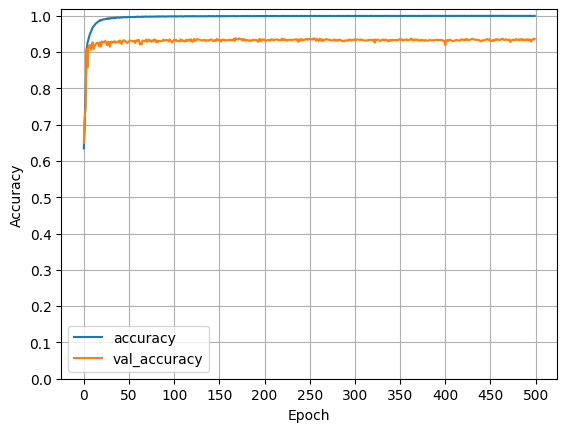

In [15]:
accuracies = model_train_info.history["accuracy"]
val_accuracies = model_train_info.history["val_accuracy"]

plt.plot(list(range(epochs)), accuracies, label = "accuracy")
plt.plot(list(range(epochs)), val_accuracies, label = "val_accuracy")
plt.legend()
plt.grid()
plt.xticks(ticks = list(range(1, epochs + 1))) 
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(ticks=list(range(0, epochs + 1, 50)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [16]:
print(f"資料: {mfcc_matrix_list.shape}")
print(f"最高準確率: {max(val_accuracies)}")

資料: (66852, 13, 44)
最高準確率: 0.9380001425743103


In [17]:
model.save(f".\\cnn_layer1_with_fake_model.h5")